In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
os.environ['TORCH'] = torch.__version__
print(f"torch version : {torch.__version__}")


%matplotlib widget
# %matplotlib inline

from argparse import ArgumentParser
from functools import reduce
import sys
import numpy as np

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, CGConv, GATConv, SuperGATConv

from data import FaissGenerator
from utils import ROOT_PATH
import utils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
device

torch version : 2.0.1+cu117


device(type='cuda')

In [3]:

class VisAttentionGNN(nn.Module):
    def __init__(
            self,
            input_dim: int,
            hidden_dim: int,
            num_hidden_layers: int,
            heads: int = 1,
            edge_dim: int = 1,
            output_dim: int = 2,
            super_GAT: bool = False,
    ) -> None:
        super().__init__()
        self.super_GAT = super_GAT

        if not self.super_GAT:
            self.layers = nn.ModuleList(
                [GATConv(in_channels=input_dim, out_channels=hidden_dim, edge_dim=edge_dim)] +
                [GATConv(in_channels=hidden_dim, out_channels=hidden_dim, edge_dim=edge_dim, heads=heads, concat=False) for _ in range(num_hidden_layers)] +
                [GATConv(in_channels=hidden_dim, out_channels=output_dim, edge_dim=edge_dim)]
            )
        else:
            self.layers = nn.ModuleList(
                [GATConv(in_channels=input_dim, out_channels=hidden_dim, edge_dim=edge_dim)] +
                [SuperGATConv(in_channels=hidden_dim, out_channels=hidden_dim, heads=heads, concats=False) for _ in range(num_hidden_layers)] +
                [GATConv(in_channels=hidden_dim, out_channels=output_dim, edge_dim=edge_dim)]
            )


    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:
        x = self.layers[0](x, edge_index, edge_attr).relu()
        if not self.super_GAT:
            x = reduce(lambda x, layer: layer(x, edge_index, edge_attr).relu(), self.layers[1:-1], x)
        else:
            x = reduce(lambda x, layer: layer(x, edge_index).relu(), self.layers[1:-1], x)
            
        x = self.layers[-1](x, edge_index, edge_attr)
        return x


def train(model: nn.Module, graph: Data, epochs: int, lr: float) -> nn.Module:
    H = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(1, epochs + 1):
        h = model(graph.x, graph.edge_index, graph.edge_attr)
        distances = F.pairwise_distance(h[graph.edge_index[0]], h[graph.edge_index[1]]).view(-1, 1)
        loss = criterion(distances, graph.edge_attr)
        H.append(h.detach().cpu())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sys.stdout.write(f'\rEpoch: {epoch}, loss: {loss.item()}')
        torch.save(model.state_dict(), f'{ROOT_PATH}/models/checkpoints/vis_gnn_model_{epoch}.pt')

    return model, H


In [4]:
def generate_visualization(model: nn.Module, graph: Data, path) -> None:
    out = model(graph.x, graph.edge_index, graph.edge_attr).detach().cpu().numpy()

    graph.to('cpu')
    plt.figure(figsize=(6, 6))

    for y in graph.y.unique():
        plt.scatter(out[graph.y == y, 0], out[graph.y == y, 1], s=5, label=y.item())

    graph.to(device)
    plt.title('VisAttetnionGNN')
    plt.legend()
    plt.savefig(path, bbox_inches='tight')


In [5]:
def create_graph(X: Tensor, y: Tensor, distances: Tensor, indexes: Tensor, nn_val: int) -> Data:
    row = torch.arange(X.shape[0]).view(-1, 1).repeat(1, nn_val).view(-1).to(device)
    col = indexes.contiguous().view(-1).to(device)
    edge_index = torch.stack([row, col], dim=0).to(device)
    edge_attr = distances.contiguous().view(-1, 1).to(device)

    return Data(x=X, y=y, edge_index=edge_index, edge_attr=edge_attr)

In [6]:
lr = 0.00001
epochs = 200
hidden_dim = 80
num_hidden_layers = 4
heads = 2

X, y, distances, indexes, nn_val = FaissGenerator.load(f'{ROOT_PATH}/data/mnist_784/dataset_nn100.pkl.lz4')
X, y, distances, indexes = tuple(map(lambda x: torch.from_numpy(x).to(device), (X, y, distances[:, 1:], indexes[:, 1:])))
graph = create_graph(X, y, distances, indexes, nn_val)

# model = VisAttentionGNN(input_dim=X.shape[1], 
#                         hidden_dim=hidden_dim, 
#                         num_hidden_layers=num_hidden_layers,
#                         heads=heads
#     ).to(device)
# model

In [11]:
import pandas as pd
pd.read_csv('/home/xsalon/studia/wizualizacje/gnn-visualization/data/mnist_784/raw784.csv').shape

(70000, 786)

Epoch: 200, loss: 340.91613769531255

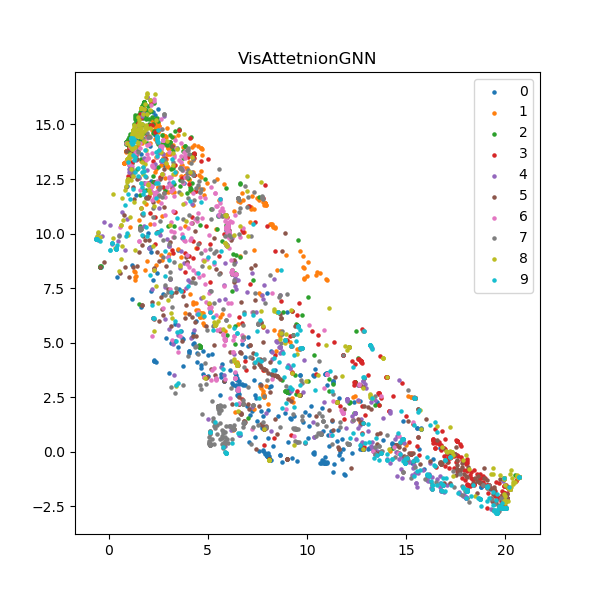

In [14]:

model, H = train(model, graph, epochs, lr)
H = np.stack(H)
model.eval()

torch.save(model.state_dict(), f'{ROOT_PATH}/models/checkpoints/vis_gnn_model_final.pt')
generate_visualization(model, graph, f'{ROOT_PATH}/models/checkpoints/vis_gnn_final.pdf');

Button(description='Run anim', style=ButtonStyle())

Button(description='Stop anim', style=ButtonStyle())

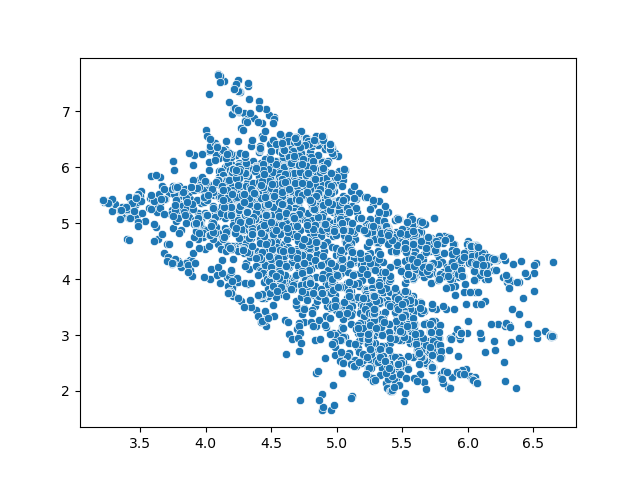

In [15]:
a = utils.EmbeddingsScatterAnimation(H, graph.y.cpu().numpy(), palette='deep')

In [16]:
# a.anim.save('gat-fps2.gif',  writer='imagemagick', fps=2)

## To działa (jeden graf - mnist 784) - daje coś jak MDS
```
lr = 0.001
epochs = 20
hidden_dim = 15
num_hidden_layers = 10

self.layers = nn.ModuleList(
            [SuperGATConv(in_channels=input_dim, out_channels=hidden_dim)] +
            [SuperGATConv(in_channels=hidden_dim, out_channels=hidden_dim) for _ in range(num_layers)] +
            [SuperGATConv(in_channels=hidden_dim, out_channels=output_dim)]
        )
```


## fajeczka
```
lr = 0.001
epochs = 100
hidden_dim = 100
num_hidden_layers = 5

self.layers = nn.ModuleList(
            [GATConv(in_channels=input_dim, out_channels=hidden_dim)] +
            [GATConv(in_channels=hidden_dim, out_channels=hidden_dim) for _ in range(num_layers)] +
            [GATConv(in_channels=hidden_dim, out_channels=output_dim)]
        )
```


